In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tqdm.auto import tqdm
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import cross_val_predict, KFold, ParameterGrid
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error
from aging.plotting import figure, legend, format_plots, PlotConfig, save_factory
import joblib

In [2]:
format_plots()
c = PlotConfig()
saver = save_factory(c.save_path / "methylation_model", tight_layout=False)

In [11]:
beh_df = pd.read_parquet(
    # "/n/scratch/users/w/wg41/bio-age-model/2024-04-11/ontogeny-bio-age-model-v2.parquet"
    '/n/scratch/users/w/wg41/bio-age-model/ontogeny-predictions.parquet'
)
meth_df = pd.read_parquet(
    "/n/groups/datta/win/longtogeny/data/epigenetics/analysis/epi_df.parquet"
)

meth_df = meth_df.astype(float).sort_index(level='age')

beh_reindexed = beh_df.loc[pd.IndexSlice[:, :, :, :, meth_df.index.get_level_values('uuid')], :].copy()
beh_reindexed = pd.DataFrame(beh_reindexed.mean(1).rename('bio_age'))
age = beh_reindexed.index.get_level_values('age')

In [12]:
def zscore(arr):
    return (arr - arr.mean()) / arr.std()

### Methylation data feature selection

Choose the features with the highest variance

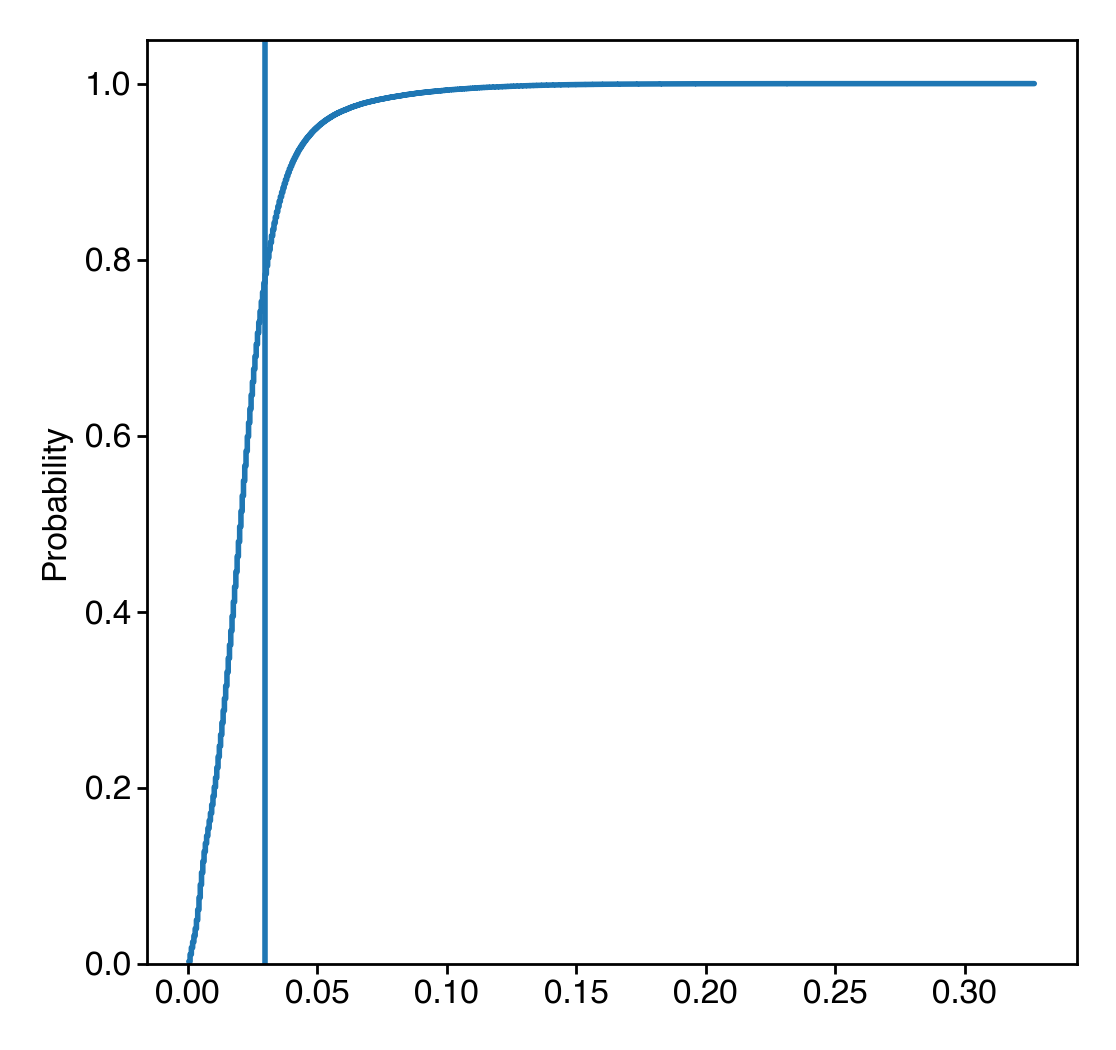

In [13]:
ax = sns.histplot(meth_df.std(), cumulative=True, stat='probability', element='step', fill=False)
ax.axvline(0.03)

In [14]:
keep_genes = meth_df.std() > 0.05
keep_genes = keep_genes.index[keep_genes]

In [15]:
filt_meth_df = meth_df[keep_genes]

In [16]:
resid = zscore(beh_reindexed['bio_age'].to_numpy() - age.to_numpy())

In [17]:
pipeline = make_pipeline(
    StandardScaler(),
    ElasticNet(max_iter=10_000),
)

In [18]:
params = {
    'elasticnet__l1_ratio': np.linspace(0.3, 1, 6),
    'elasticnet__alpha': np.logspace(-3, 0, 8),
}

grid = ParameterGrid(params)

In [ ]:
out = []
for param_set in tqdm(list(grid)):
    pipeline.set_params(**param_set)
    _score = r2_score(
        resid,
        cross_val_predict(
            pipeline.set_params(**param_set),
            filt_meth_df,
            resid[:, None],
            cv=KFold(n_splits=7, shuffle=True, random_state=0),
            n_jobs=-1,
        ).squeeze(),
    )
    param_set['score'] = _score
    out.append(param_set)
out = pd.DataFrame(out)

  0%|          | 0/48 [00:00<?, ?it/s]

In [ ]:
sns.heatmap(
    pd.pivot_table(
        out,
        index="elasticnet__l1_ratio",
        columns="elasticnet__alpha",
        values="score",
    ),
    cmap="mako",
    vmin=0,
    annot=True
)

In [ ]:
ax = pd.pivot_table(out, index='elasticnet__l1_ratio', columns='elasticnet__alpha', values='score').T[0.58].plot()
ax.set(xscale='log')

In [ ]:
param_set

In [74]:
param_set = {
    'elasticnet__alpha': 0.1,
    'elasticnet__l1_ratio': 0.5,
}
_score = r2_score(
    resid,
    cross_val_predict(
        pipeline.set_params(**param_set),
        filt_meth_df,
        resid[:, None],
        cv=KFold(n_splits=7, shuffle=True, random_state=0),
        n_jobs=-1,
    ).squeeze(),
)
_score

0.22073023564611804

In [ ]:
p = pipeline.set_params(**param_set)
p.fit(filt_meth_df, resid[:, None])

In [90]:
coefs = p.named_steps['elasticnet'].coef_

In [91]:
coefs.shape

(13864,)

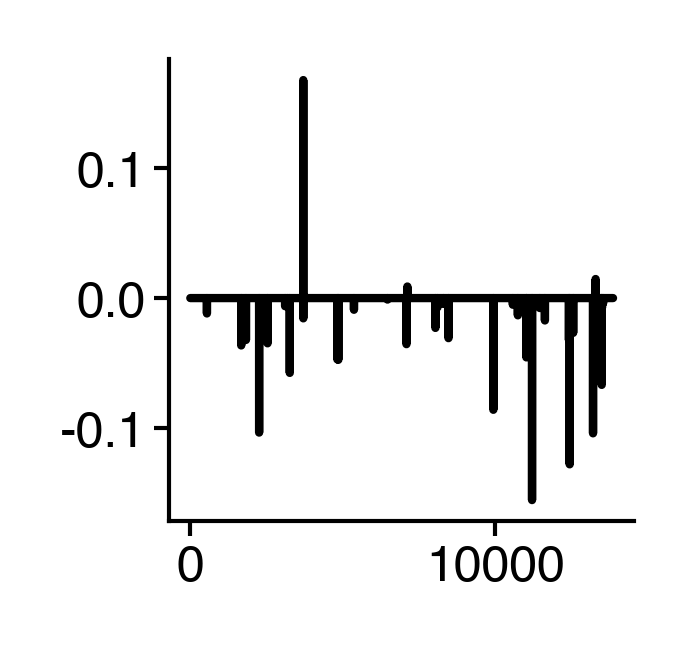

In [87]:
fig = figure(1, 1)
plt.plot(coefs, color='k')
sns.despine()

In [88]:
np.sum(coefs != 0)

38

### Run bootstrap for r2

In [127]:
n_boot = 100
param_set = {
    "elasticnet__alpha": 0.1,
    "elasticnet__l1_ratio": 0.5,
}
p = pipeline.set_params(**param_set)
np.random.seed(0)

scores = {
    "mae": [],
    "r2": [],
}
for i in tqdm(range(n_boot)):
    # idx = np.random.choice(np.arange(len(resid)), len(resid))
    # x = filt_meth_df.iloc[idx]
    # y = resid[idx][:, None]
    x = filt_meth_df
    y = resid[:, None]
    preds = cross_val_predict(
        p,
        x,
        y,
        # cv=KFold(n_splits=7, shuffle=True, random_state=0),
        cv=KFold(n_splits=7, shuffle=True, random_state=i),
        n_jobs=-1,
    ).squeeze()
    scores["r2"].append(r2_score(y, preds))
    scores["mae"].append(mean_absolute_error(y, preds))

  0%|          | 0/100 [00:00<?, ?it/s]

In [128]:
param_set = {
    "elasticnet__alpha": 0.1,
    "elasticnet__l1_ratio": 0.5,
}
p = pipeline.set_params(**param_set)
np.random.seed(0)

shuff_scores = {
    "mae": [],
    "r2": [],
}
for i in tqdm(range(n_boot)):
    # idx = np.random.choice(np.arange(len(resid)), len(resid))
    # x = filt_meth_df.iloc[idx]
    # y = resid[idx][:, None]
    x = filt_meth_df
    y = resid[:, None]
    np.random.shuffle(y)
    preds = cross_val_predict(
        p,
        x,
        y,
        # cv=KFold(n_splits=7, shuffle=True, random_state=0),
        cv=KFold(n_splits=7, shuffle=True, random_state=i),
        n_jobs=-1,
    ).squeeze()
    shuff_scores["r2"].append(r2_score(y, preds))
    shuff_scores["mae"].append(mean_absolute_error(y, preds))

  0%|          | 0/100 [00:00<?, ?it/s]

/tmp/ipykernel_16615/2880265538.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set(ylabel='Heldout R2', xticklabels=['Observed', 'Shuffle'], ylim=(None, 0.5))


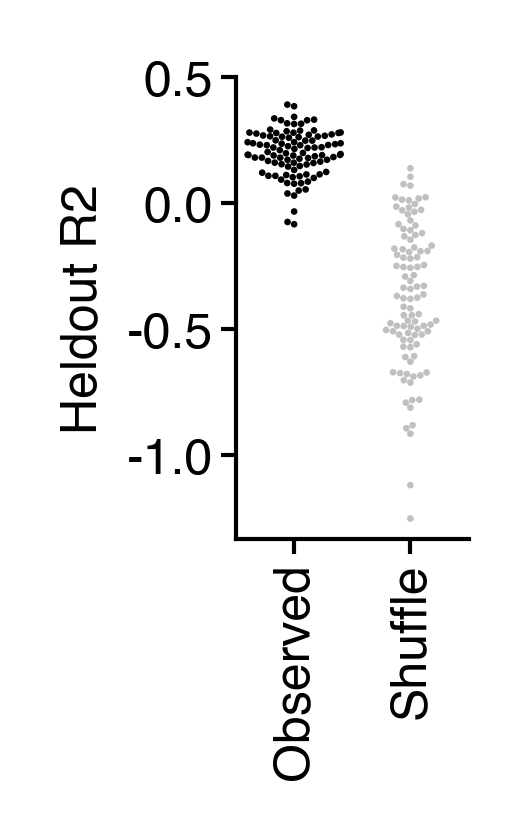

In [133]:
fig = figure(0.5, 1)
ax = sns.swarmplot(data=[scores['r2'], shuff_scores['r2']], size=0.8, palette=['k', 'silver'])
ax.set(ylabel='Heldout R2', xticklabels=['Observed', 'Shuffle'], ylim=(None, 0.5))
plt.xticks(rotation=90)
sns.despine()
saver(fig, "heldout-r2");

/tmp/ipykernel_16615/3656409749.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set(ylabel='Heldout MAE', xticklabels=['Observed', 'Shuffle'], ylim=(0, None))
/home/wg41/miniconda3/envs/aging/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 13.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


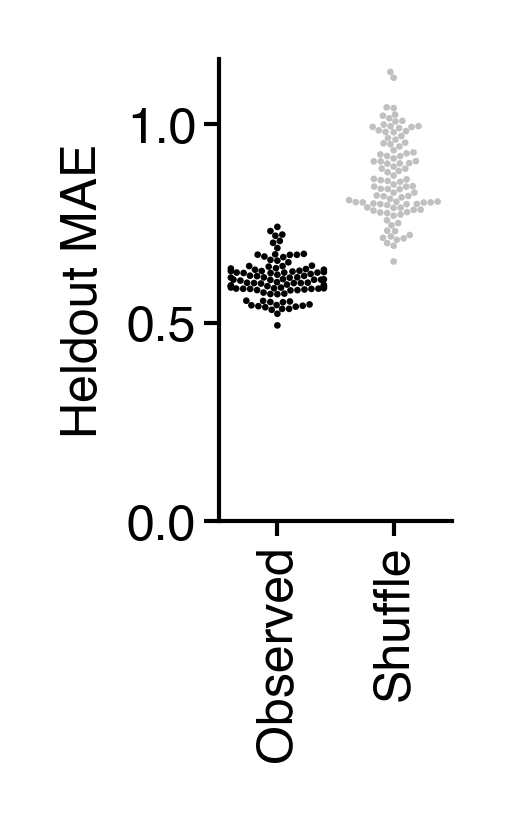

In [134]:
fig = figure(0.5, 1)
ax = sns.swarmplot(data=[scores['mae'], shuff_scores['mae']], size=0.8, palette=['k', 'silver'])
ax.set(ylabel='Heldout MAE', xticklabels=['Observed', 'Shuffle'], ylim=(0, None))
plt.xticks(rotation=90)
sns.despine()
saver(fig, "heldout-mae");

In [151]:
x = filt_meth_df
y = resid[:, None]
preds = cross_val_predict(
    p,
    x,
    y,
    cv=KFold(n_splits=7, shuffle=True, random_state=3),
    n_jobs=-1,
).squeeze()


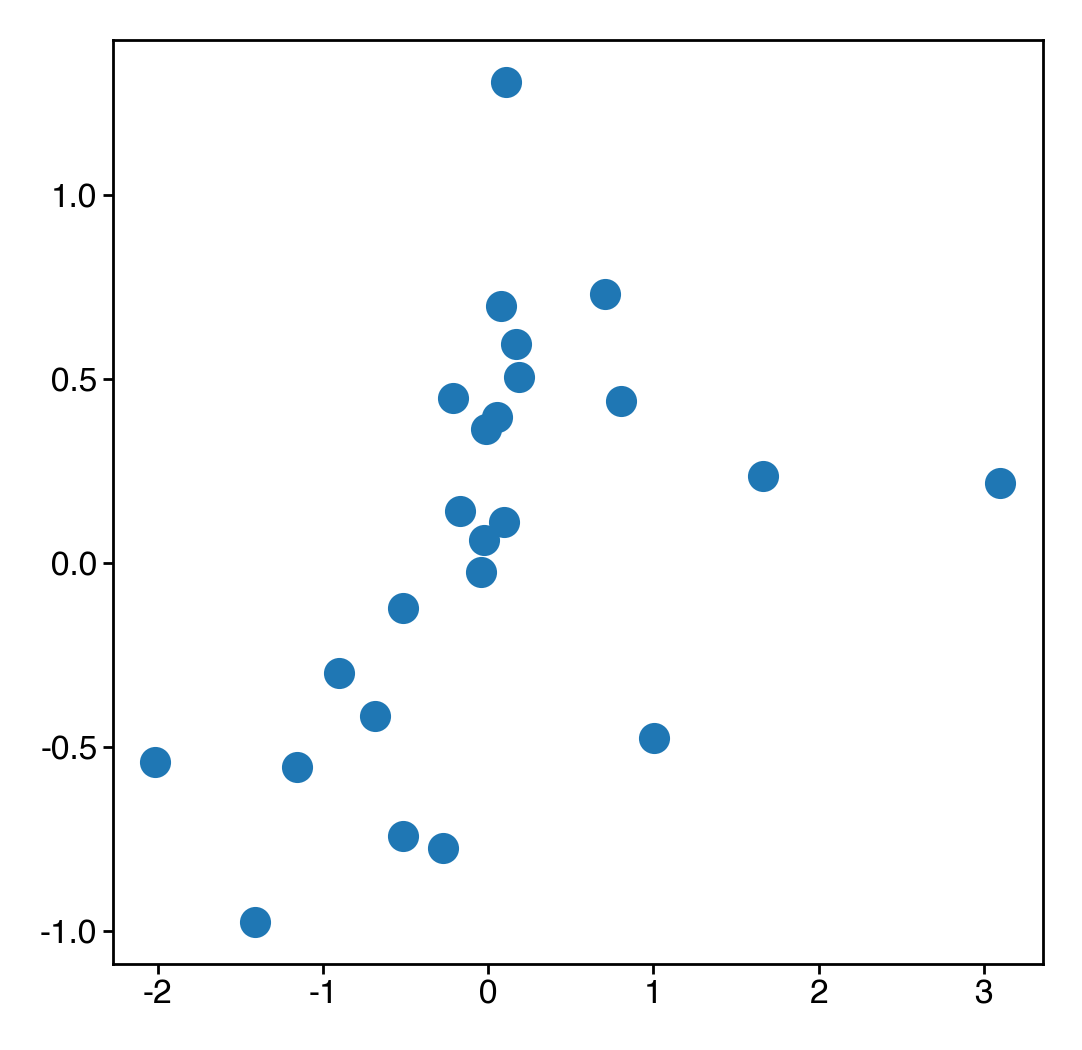

In [152]:
plt.scatter(y, preds)

## Do same thing, but using just the few features that come from the lasso regression